# Labeling: Fixed Time Horizon

## Abstract

Fixed Horizon is a classification labeling technique in which time-indexed data is labeled according to whether it exceeds, falls in between, or is less than a threshold. This method is most commonly used with time bars, but also be applied to any time-indexed data such as dollar or volume bars. The subsequent labeled data can then be used as training and test data for ML algorithms.

The following paper outlines the technique in greater depth, and is followed closely in this notebook tutorial: ["Classification-based Financial Markets Prediction using Deep Neural Networks"](https://arxiv.org/abs/1603.08604) by _Dixon et al._ (2016). 


## How it works

Fixed time horizon is a common method used in labeling financial data, usually applied on time bars. The return relative to $t_0$ over a time horizon $h$ is calculated as follows, assuming returns are lagged to make them forward-looking:

   $$r_{t0,t1} = \frac{p_{t1}}{p_{t0}} - 1$$

Where $t_1$ is the time bar after a fixed horizon has passed, and $p_{t0}, p_{t1}$
are prices at times $t_0, t_1$. This method assigns a label based on comparison of return to a threshold $\tau$
\[Lopez de Prado 2018\]:

$$
     \begin{equation}
     \begin{split}
       L_{t0, t1} = \begin{cases}
       -1 &\ \text{if} \ \ r_{t0, t1} < -\tau\\
       0 &\ \text{if} \ \ -\tau \leq r_{t0, t1} \leq \tau\\
       1 &\ \text{if} \ \ r_{t0, t1} > \tau
       \end{cases}
     \end{split}
     \end{equation}
$$

To avoid overlapping return windows, rather than specifying $h$, the user is given the option of resampling the returns to get the desired return period. Optionally, returns can be standardized by scaling by the mean and standard deviation of a rolling window. If threshold is a pd.Series, **threshold.index and prices.index must match**; otherwise labels will fail to be returned. If resampling is used, the threshold must match the index of prices after resampling. This is to avoid the user being forced to manually fill in thresholds. Acceptable strings inputs for resampling can be found [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects).

Though time bars are the most common format for financial data, there can be potential problems with over-reliance on time bars. Time bars exhibit high seasonality, as trading behavior may be quite different at the open or close versus midday; thus it will not be informative to apply the same threshold on a non-uniform distribution. Solutions include applying the fixed horizon method to tick or volume bars instead of time bars, using data sampled at the same time every day (e.g. closing prices) or inputting a dynamic threshold as a pd.Series corresponding to the timestamps in the dataset. However, the fixed horizon method will always fail to capture information about the path of the prices [Lopez de Prado, 2018].

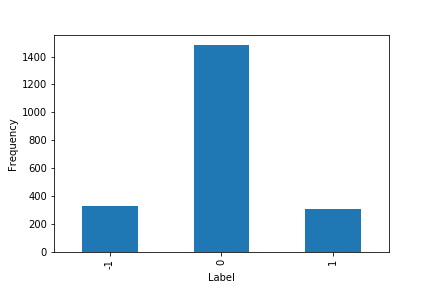

In [1]:
from IPython.display import Image
Image(filename='images/fixed_horizon_labels_example.png')

_*Fig. 1:*_ Distribution of labels for standardized returns on closing prices of SPY in the time period from Jan 2008 to July 2016 using a 20-day rolling window for the standard deviation.

---
## Examples of use

In [2]:
# Import packages
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Import MlFinlab tools
from mlfinlab.labeling.fixed_time_horizon import fixed_time_horizon

MLFINLAB_API_KEY is valid.


In [3]:
# Load price data. pd.Series is shown but pd.DataFrame works as well
msft = yf.Ticker('MSFT')
msft_df = msft.history(start='2010-1-1', end ='2020-5-18')

close = msft_df['Close']
close.head()

Date
2010-01-04 00:00:00-05:00    23.572369
2010-01-05 00:00:00-05:00    23.579983
2010-01-06 00:00:00-05:00    23.435268
2010-01-07 00:00:00-05:00    23.191555
2010-01-08 00:00:00-05:00    23.351494
Name: Close, dtype: float64

### Labeling financial time series

In [4]:
# Getting labels for a constant threshold of 1%. Will return 1 if the daily return is greater than 1%,
# -1 if less than -1%, and  0 if in between
bars1 = fixed_time_horizon(prices=close, threshold=0.01, lag=True)

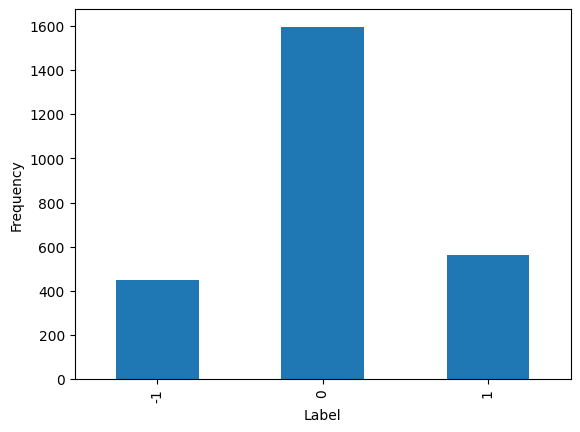

In [5]:
ax1 = bars1.value_counts().reindex([-1, 0, 1]).plot(kind='bar', x='label', y='frequency')
ax1.set_xlabel('Label')
ax1.set_ylabel('Frequency');

Predictably, lowering the threshold results in fewer 0 labels.

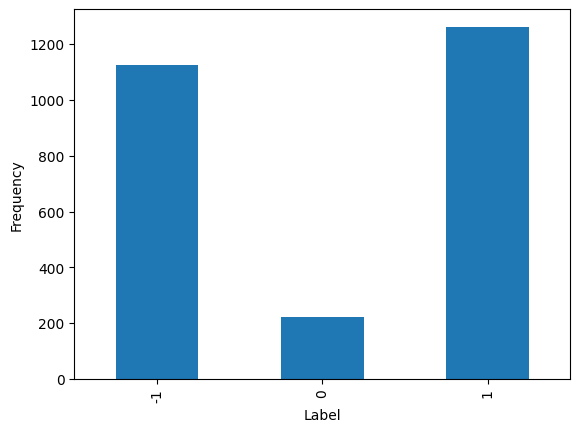

In [6]:
bars2 = fixed_time_horizon(prices=close, threshold=0.001, lag=True)
ax2 = bars2.value_counts().reindex([-1, 0, 1]).plot(kind='bar', x='label', y='frequency')
ax2.set_xlabel('Label')
ax2.set_ylabel('Frequency');

### Labeling with dynamic threshold

A major problem with the fixed time horizon method is the seasonality of the data. Time bars in the middle of the trading day would look very different than those at the open or close. One way to get around this is to only use data which has been collected at the same time per day, such as close prices. Another method is to apply a dynamic threshold which can adjust for such differences. 

We will demonstrate two methods of setting a dynamic threshold:
1. Using a rolling standard deviation.
2. Using SPY as the market return.


In [7]:
# Rolling standard deviation
msft_returns = close.pct_change(periods=1).shift(-1)
rolling_std = msft_returns.rolling(10).std()

Because the first 9 values in the rolling_std are NaN due to the rolling window, there is no threshold to compare the first 9 returns to. So we must remove the first 9 returns as they are not labeled.

In [8]:
bars3 = fixed_time_horizon(prices=close, threshold=rolling_std, lag=True)
bars3 = bars3.iloc[9:]

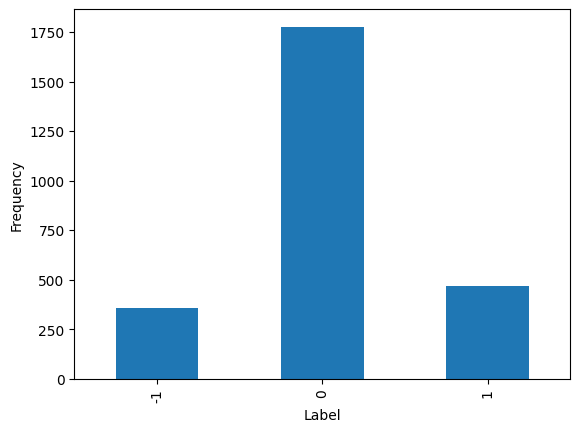

In [9]:
ax3 = bars3.value_counts().reindex([-1, 0, 1]).plot(kind='bar', x='label', y='frequency')
ax3.set_xlabel('Label')
ax3.set_ylabel('Frequency');

In [10]:
# Threshold on market returns
spy = yf.Ticker('SPY')
spy_df = spy.history(start='2010-1-1', end ='2020-5-18')
market_close = spy_df['Close']

market_returns = market_close.pct_change(1).shift(-1)
market_returns.head()

Date
2010-01-04 00:00:00-05:00    0.002647
2010-01-05 00:00:00-05:00    0.000704
2010-01-06 00:00:00-05:00    0.004221
2010-01-07 00:00:00-05:00    0.003328
2010-01-08 00:00:00-05:00    0.001397
Name: Close, dtype: float64

In [11]:
bars4 = fixed_time_horizon(prices=close, threshold=market_returns, lag=True)

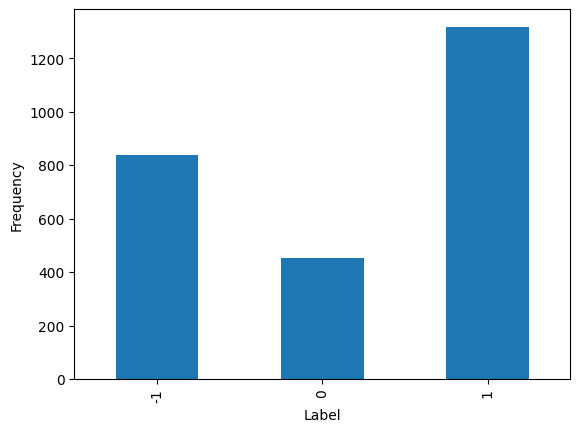

In [12]:
ax4 = bars4.value_counts().reindex([-1, 0, 1]).plot(kind='bar', x='label', y='frequency')
ax4.set_xlabel('Label')
ax4.set_ylabel('Frequency');

These 2 methods of setting a dynamic threshold accomplish slightly different things. By setting the threshold equal to the rolling standard deviation, we can see if the day's volatility is higher than in recent days. By setting the threshold equal to the return on SPY, we can see if our stock's return was more volatile than the market average for the day.

### Labeling with standardization 

Scaling each return by the mean and standard deviation is also a potential solution in getting around the non-homogeneity of the data, as it could adjust for volatility differences between different bars. If standardization is desired, a rolling window must be given.

In [13]:
close.pct_change(periods=1).shift(-1)

Date
2010-01-04 00:00:00-05:00    0.000323
2010-01-05 00:00:00-05:00   -0.006137
2010-01-06 00:00:00-05:00   -0.010399
2010-01-07 00:00:00-05:00    0.006896
2010-01-08 00:00:00-05:00   -0.012720
                               ...   
2020-05-11 00:00:00-04:00   -0.022652
2020-05-12 00:00:00-04:00   -0.015123
2020-05-13 00:00:00-04:00    0.004339
2020-05-14 00:00:00-04:00    0.014568
2020-05-15 00:00:00-04:00         NaN
Name: Close, Length: 2610, dtype: float64

In [14]:
bars5 = fixed_time_horizon(prices=close, threshold=1, lag=True, standardized=True, window=5)

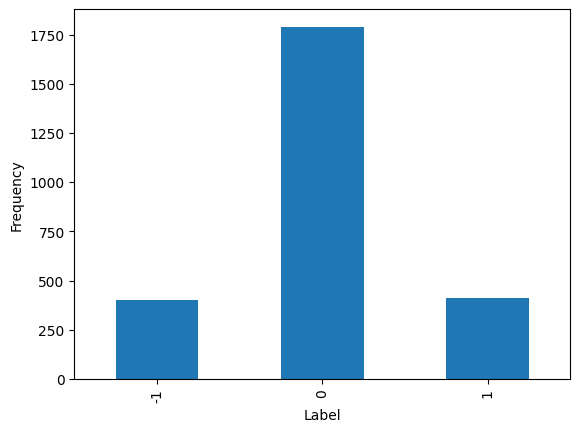

In [15]:
ax5 = bars5.value_counts().reindex([-1, 0, 1]).plot(kind='bar', x='label', y='frequency')
ax5.set_xlabel('Label')
ax5.set_ylabel('Frequency');

### Labeling with resampling

Sometimes the data is more granular then necessary. Suppose we only want to predict returns on a weekly timescale but have daily data. Then we can resample the prices weekly so that only the price at the end of each week gets sampled. 

In [16]:
bars6 = fixed_time_horizon(prices=close, threshold=1, resample_by='W', lag=True, standardized=True, window=4)

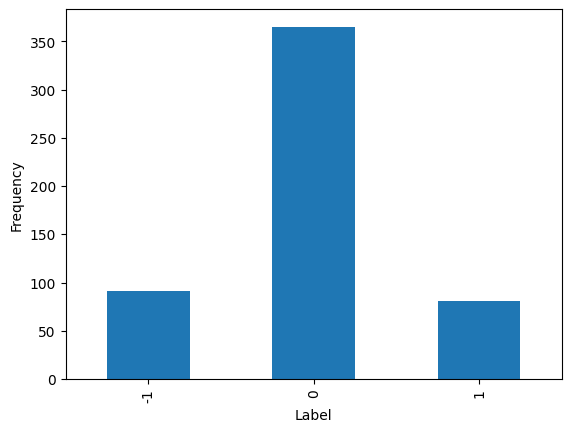

In [17]:
ax6 = bars6.value_counts().reindex([-1, 0, 1]).plot(kind='bar', x='label', y='frequency')
ax6.set_xlabel('Label')
ax6.set_ylabel('Frequency');

### Error Handling

A warning is raised if window is greater than the length of the data. In this case, the function will still run, but all labels will be NaN. An exception is raised if standardized is set to True but the window is not specified correctly as an int. An exception is also raised if the index of threshold does not match the index of prices, as this will cause the labeling to fail.

In [18]:
try:
    fixed_time_horizon(close, 0.01, standardized=True, window=9999999).head()
except Warning as warn:
    print(warn)

/home/ariadne/Projects/mlfinlab_premium/mlfinlab/labeling/fixed_time_horizon.py:70: UserWarning: window is greater than the length of the Series. All labels will be NaN.
  warnings.warn('window is greater than the length of the Series. All labels will be NaN.', UserWarning)


In [19]:
threshold = pd.Series([0.01]*10)
try:
    fixed_time_horizon(prices=close[:10], threshold=threshold)
except Exception as exc:
    print(exc)

prices.index and threshold.index must match! If prices are resampled, the threshold index must match the resampled prices index.


In [20]:
try:
    fixed_time_horizon(prices=close, threshold=0.01, lag=True, standardized=True, window='str')
except Exception as exc:
    print(exc)

When standardized is True, window must be int.


---
## Conclusion

This notebook presents the fixed horizon method, a simple method of labeling data for later use in machine learning algorithms. In this process:
 - Forward (lagged) returns for assets are calculated based on time-indexed data, usually in the form of time bars. If applicable, the returns may be calculated from resampled prices.
 - The forward return is compared to a threshold for the return. The threshold can be a constant, or a pd.Series corresponding to every timestamp in the data.
 - Each observation is compared to the threshold, and is labeled -1 if it is below -threshold, 0 if it is between -threshold and +threshold, and 1 if it is greater than +threshold.to

This method works with the prices input being pd.Series or pd.DataFrame. In Dixon's paper, the data is labeled using this method. Subsequently a neural network is trained to predict the label based on the data. A simple trading strategy in which a long position is taken if a ticker is classified as 1, and short if it's classified at -1, can then be applied. 

## References

1. Dixon, M., Klabjan, D. and Jin Hoon, B., 2020. Classification-based Financial Markets Prediction using Deep Neural Networks. arXiv, [online] Available at: https://arxiv.org/abs/1603.08604

2. López de Prado, M., 2018. Advances In Financial Machine Learning. pp.43-44.

3. López de Prado, M., 2020. Machine Learning For Asset Managers. pp.65-66.
